# Supplier Risk Scoring System
## AI-Powered Predictive Analytics for Supply Chain Risk Management

**Author:** SWRAJ PALEKAR  
**Date:** 08-02-2026  
**Project Goal:** Build a machine learning system to predict supplier risk and enable proactive supply chain management

---

### Business Context

Supply chain disruptions cost companies an average of **$184M annually** (Source: McKinsey). Traditional supplier evaluation relies on quarterly reviews and subjective assessments. By the time issues appear in reports, production delays and quality problems have already impacted the bottom line.

This project develops a **data-driven, predictive approach** to supplier risk management that:
- Identifies high-risk suppliers 30-60 days in advance
- Provides actionable risk tiers for decision-making
- Reveals key risk drivers to guide mitigation strategies

---
## 1. Setup & Data Generation

First, we'll import required libraries and generate synthetic supplier data that models realistic supply chain patterns.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Set random seed for reproducibility
np.random.seed(42)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


### Generate Synthetic Supplier Data

We'll create a realistic dataset with 75 suppliers across different quality tiers:
- **High quality (30%):** 92-99% on-time, <2% defect rate
- **Medium quality (50%):** 80-92% on-time, 2-6% defect rate  
- **Low quality (20%):** 65-80% on-time, 6-15% defect rate

Normally, an ERP will constantly feed data here

In [2]:
def generate_supplier_data(n_suppliers=75, months=12):
    """
    Generate synthetic supplier performance data
    """
    
    supplier_names = [f"Supplier_{i:03d}" for i in range(1, n_suppliers + 1)]
    categories = ['Electronics', 'Raw Materials', 'Packaging', 'Components', 'Services']
    regions = ['North America', 'Europe', 'Asia', 'South America']
    
    data = []
    
    for supplier in supplier_names:
        category = np.random.choice(categories)
        region = np.random.choice(regions)
        
        # Define supplier quality tier
        quality_tier = np.random.choice(['high', 'medium', 'low'], p=[0.3, 0.5, 0.2])
        
        if quality_tier == 'high':
            base_on_time = np.random.uniform(0.92, 0.99)
            base_defect = np.random.uniform(0.001, 0.02)
            base_leadtime = np.random.uniform(5, 10)
            base_payment_compliance = np.random.uniform(0.95, 1.0)
            base_response_hours = np.random.uniform(2, 8)
        elif quality_tier == 'medium':
            base_on_time = np.random.uniform(0.80, 0.92)
            base_defect = np.random.uniform(0.02, 0.06)
            base_leadtime = np.random.uniform(10, 20)
            base_payment_compliance = np.random.uniform(0.85, 0.95)
            base_response_hours = np.random.uniform(8, 24)
        else:
            base_on_time = np.random.uniform(0.65, 0.80)
            base_defect = np.random.uniform(0.06, 0.15)
            base_leadtime = np.random.uniform(20, 35)
            base_payment_compliance = np.random.uniform(0.70, 0.85)
            base_response_hours = np.random.uniform(24, 72)
        
        # Generate monthly variations
        monthly_data = []
        for month in range(months):
            on_time_rate = np.clip(base_on_time + np.random.normal(0, 0.05), 0, 1)
            defect_rate = np.clip(base_defect + np.random.normal(0, 0.01), 0, 1)
            avg_leadtime = np.clip(base_leadtime + np.random.normal(0, 3), 1, 60)
            payment_compliance = np.clip(base_payment_compliance + np.random.normal(0, 0.03), 0, 1)
            response_hours = np.clip(base_response_hours + np.random.normal(0, 5), 0.5, 200)
            
            monthly_data.append({
                'on_time_rate': on_time_rate,
                'defect_rate': defect_rate,
                'avg_leadtime_days': avg_leadtime,
                'payment_compliance': payment_compliance,
                'avg_response_hours': response_hours
            })
        
        # Calculate aggregated metrics
        on_time_rates = [m['on_time_rate'] for m in monthly_data]
        defect_rates = [m['defect_rate'] for m in monthly_data]
        leadtimes = [m['avg_leadtime_days'] for m in monthly_data]
        
        recent_on_time = np.mean(on_time_rates[-3:])
        recent_defect = np.mean(defect_rates[-3:])
        
        data.append({
            'supplier_id': supplier,
            'supplier_name': supplier.replace('_', ' '),
            'category': category,
            'region': region,
            'quality_tier': quality_tier,
            'avg_on_time_rate': np.mean(on_time_rates),
            'recent_on_time_rate': recent_on_time,
            'on_time_trend': recent_on_time - np.mean(on_time_rates[:3]),
            'delivery_consistency': 1 - np.std(on_time_rates),
            'avg_defect_rate': np.mean(defect_rates),
            'recent_defect_rate': recent_defect,
            'defect_trend': recent_defect - np.mean(defect_rates[:3]),
            'avg_leadtime_days': np.mean(leadtimes),
            'leadtime_variability': np.std(leadtimes),
            'max_leadtime_days': np.max(leadtimes),
            'payment_compliance_rate': np.mean([m['payment_compliance'] for m in monthly_data]),
            'price_volatility': np.random.uniform(0.02, 0.15),
            'order_fulfillment_rate': np.clip(np.random.normal(0.92, 0.08), 0.7, 1.0),
            'avg_response_hours': np.mean([m['avg_response_hours'] for m in monthly_data]),
            'response_consistency': 1 - np.std([m['avg_response_hours'] for m in monthly_data]) / 24,
            'total_orders_12mo': np.random.randint(50, 500),
            'avg_order_value': np.random.randint(5000, 100000),
            'single_source': np.random.choice([True, False], p=[0.2, 0.8]),
            'critical_component': np.random.choice([True, False], p=[0.3, 0.7]),
            'contract_expiry_days': np.random.randint(-30, 365),
        })
    
    df = pd.DataFrame(data)
    df['annual_spend'] = df['total_orders_12mo'] * df['avg_order_value']
    
    # Add external risk factors
    geo_risk = {'North America': 2, 'Europe': 3, 'Asia': 5, 'South America': 4}
    category_risk = {'Electronics': 7, 'Raw Materials': 6, 'Packaging': 3, 'Components': 8, 'Services': 2}
    
    df['geographic_risk'] = df['region'].map(geo_risk)
    df['category_concentration_risk'] = df['category'].map(category_risk)
    
    return df

# Generate the data
df = generate_supplier_data(n_suppliers=75, months=12)

print(f"✓ Generated data for {len(df)} suppliers")
print(f"✓ Total columns: {len(df.columns)}")
print(f"\nDataset shape: {df.shape}")

✓ Generated data for 75 suppliers
✓ Total columns: 28

Dataset shape: (75, 28)


### Quick Data Overview

In [3]:
# Display first few rows
print("Sample of supplier data:")
df[['supplier_name', 'category', 'region', 'avg_on_time_rate', 'avg_defect_rate', 'annual_spend']].head(10)

Sample of supplier data:


,supplier_name,category,region,avg_on_time_rate,avg_defect_rate,annual_spend
0,Supplier 001,Components,North America,0.954681,0.013847,7719070
1,Supplier 002,Packaging,South America,0.896723,0.038142,7996919
2,Supplier 003,Services,Asia,0.903730,0.023527,3037718
3,Supplier 004,Raw Materials,Europe,0.915677,0.024616,4936656
4,Supplier 005,Services,South America,0.916918,0.008002,2342721
5,Supplier 006,Electronics,Asia,0.862704,0.059012,31215096
6,Supplier 007,Raw Materials,Europe,0.868160,0.025784,636104
7,Supplier 008,Electronics,North America,0.861006,0.047735,13415574
8,Supplier 009,Electronics,North America,0.876017,0.019077,11625185
9,Supplier 010,Packaging,Europe,0.902554,0.006701,9199484


In [4]:
# Summary statistics
print("Key Performance Metrics Summary:")
df[['avg_on_time_rate', 'avg_defect_rate', 'avg_leadtime_days', 'payment_compliance_rate']].describe()

Key Performance Metrics Summary:


,avg_on_time_rate,avg_defect_rate,avg_leadtime_days,payment_compliance_rate
count,75.000000,75.000000,75.000000,75.000000
mean,0.857200,0.045768,15.191611,0.896332
std,0.084792,0.034913,7.012702,0.070383
min,0.647675,0.005144,4.553673,0.718484
25%,0.818765,0.021544,9.448734,0.871233
50%,0.862704,0.039111,14.509188,0.906933
75%,0.917126,0.052360,18.061761,0.943397
max,0.984105,0.144827,34.632426,0.985638


In [5]:
# Distribution by quality tier (hidden variable for validation)
print("\nSupplier Distribution by Quality Tier:")
print(df['quality_tier'].value_counts())
print("\nSupplier Distribution by Region:")
print(df['region'].value_counts())
print("\nSupplier Distribution by Category:")
print(df['category'].value_counts())


Supplier Distribution by Quality Tier:
medium    45
high      18
low       12
Name: quality_tier, dtype: int64

Supplier Distribution by Region:
Asia             21
Europe           21
South America    18
North America    15
Name: region, dtype: int64

Supplier Distribution by Category:
Services         19
Packaging        16
Components       14
Raw Materials    13
Electronics      13
Name: category, dtype: int64


---
## 2. Exploratory Data Analysis

Before building the risk model, let's understand the patterns in this data.

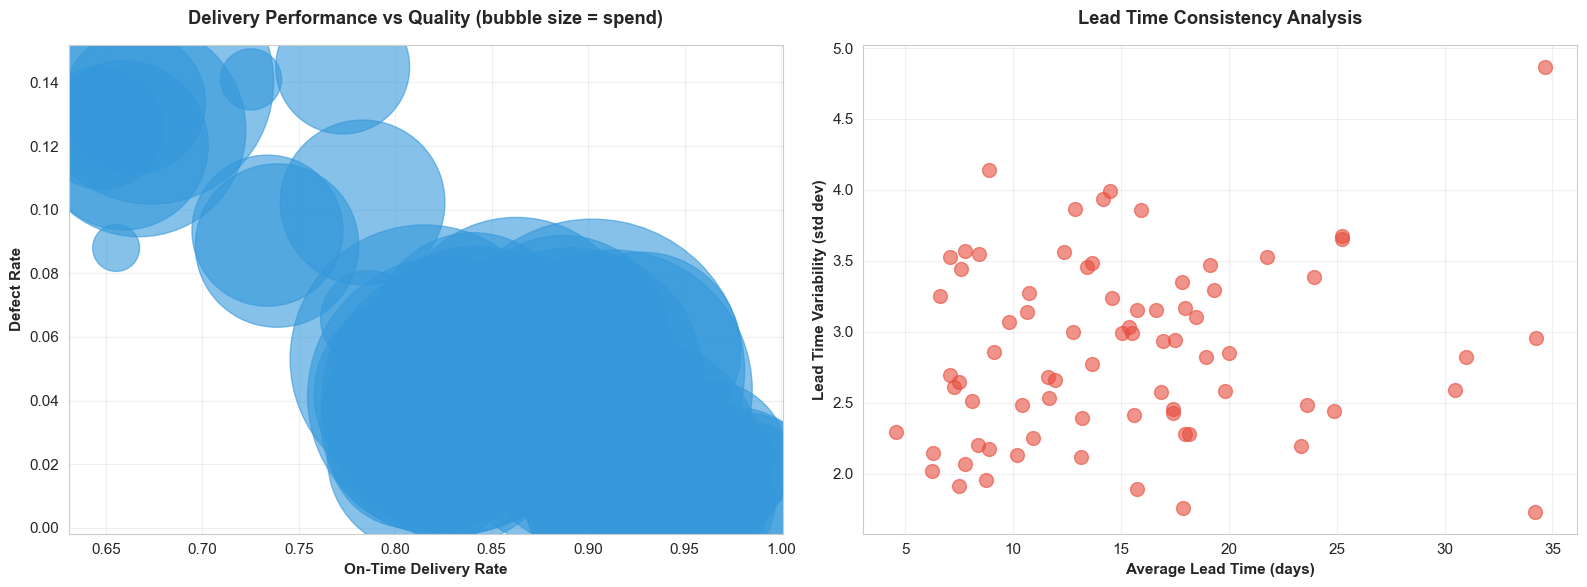

Key Observation: Suppliers with lower on-time rates tend to have higher defect rates
This suggests underlying operational issues affect multiple performance dimensions


In [6]:
# Correlation analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# On-time delivery vs defect rate
axes[0].scatter(df['avg_on_time_rate'], df['avg_defect_rate'], 
                alpha=0.6, s=df['annual_spend']/1000, c='#3498db')
axes[0].set_xlabel('On-Time Delivery Rate', fontweight='bold')
axes[0].set_ylabel('Defect Rate', fontweight='bold')
axes[0].set_title('Delivery Performance vs Quality (bubble size = spend)', fontweight='bold', pad=15)
axes[0].grid(alpha=0.3)

# Lead time vs variability
axes[1].scatter(df['avg_leadtime_days'], df['leadtime_variability'], 
                alpha=0.6, s=100, c='#e74c3c')
axes[1].set_xlabel('Average Lead Time (days)', fontweight='bold')
axes[1].set_ylabel('Lead Time Variability (std dev)', fontweight='bold')
axes[1].set_title('Lead Time Consistency Analysis', fontweight='bold', pad=15)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observation: Suppliers with lower on-time rates tend to have higher defect rates")
print("This suggests underlying operational issues affect multiple performance dimensions")

---
## 3. Risk Scoring Methodology

### Weighted Risk Scoring

We will calculate risk scores using a weighted combination of five key components:

1. **Delivery Performance (30%)** - On-time delivery rate and trends
2. **Quality Metrics (25%)** - Defect rates and quality trends
3. **Lead Time Variability (20%)** - Consistency and predictability
4. **Financial Stability (15%)** - Payment compliance and price volatility
5. **Responsiveness (10%)** - Communication and response times

Risk scores range from **0-100** (higher = more risk)

In [7]:
def calculate_risk_scores(df, weights=None):
    """
    Calculate comprehensive risk scores for suppliers
    """
    
    if weights is None:
        weights = {
            'delivery_performance': 0.30,
            'quality_metrics': 0.25,
            'lead_time_variability': 0.20,
            'financial_stability': 0.15,
            'responsiveness': 0.10
        }
    
    scored_df = df.copy()
    
    # 1. Delivery Risk
    scored_df['delivery_risk'] = (1 - scored_df['avg_on_time_rate']) * 100
    scored_df.loc[scored_df['on_time_trend'] < -0.05, 'delivery_risk'] *= 1.2
    
    # 2. Quality Risk
    scored_df['quality_risk'] = scored_df['avg_defect_rate'] * 1000
    scored_df['quality_risk'] = scored_df['quality_risk'].clip(0, 100)
    scored_df.loc[scored_df['defect_trend'] > 0.01, 'quality_risk'] *= 1.15
    
    # 3. Lead Time Risk
    max_var = scored_df['leadtime_variability'].max()
    scored_df['leadtime_risk'] = (scored_df['leadtime_variability'] / max_var) * 100
    
    # 4. Financial Risk
    scored_df['financial_risk'] = (1 - scored_df['payment_compliance_rate']) * 100
    scored_df['financial_risk'] += scored_df['price_volatility'] * 200
    scored_df['financial_risk'] = scored_df['financial_risk'].clip(0, 100)
    
    # 5. Responsiveness Risk
    max_response = scored_df['avg_response_hours'].quantile(0.95)
    scored_df['responsiveness_risk'] = (scored_df['avg_response_hours'] / max_response) * 100
    scored_df['responsiveness_risk'] = scored_df['responsiveness_risk'].clip(0, 100)
    
    # Calculate weighted composite score
    scored_df['base_risk_score'] = (
        scored_df['delivery_risk'] * weights['delivery_performance'] +
        scored_df['quality_risk'] * weights['quality_metrics'] +
        scored_df['leadtime_risk'] * weights['lead_time_variability'] +
        scored_df['financial_risk'] * weights['financial_stability'] +
        scored_df['responsiveness_risk'] * weights['responsiveness']
    )
    
    # Apply risk modifiers
    scored_df['risk_score'] = scored_df['base_risk_score'].copy()
    scored_df.loc[scored_df['single_source'] == True, 'risk_score'] *= 1.15
    scored_df.loc[scored_df['critical_component'] == True, 'risk_score'] *= 1.10
    scored_df.loc[scored_df['contract_expiry_days'] < 0, 'risk_score'] *= 1.10
    
    # Add external risk factors
    scored_df['risk_score'] += scored_df['geographic_risk'] * 0.5
    scored_df['risk_score'] += scored_df['category_concentration_risk'] * 0.3
    
    scored_df['risk_score'] = scored_df['risk_score'].clip(0, 100)
    
    # Assign risk tiers
    scored_df['risk_tier'] = pd.cut(
        scored_df['risk_score'],
        bins=[0, 30, 60, 100],
        labels=['Low', 'Medium', 'High']
    )
    
    return scored_df

# Calculate risk scores
df = calculate_risk_scores(df)

print("✓ Risk scores calculated for all suppliers")
print(f"\nRisk Distribution:")
print(df['risk_tier'].value_counts())

✓ Risk scores calculated for all suppliers

Risk Distribution:
Medium    49
Low       15
High      11
Name: risk_tier, dtype: int64


In [8]:
# Show top 10 highest risk suppliers
print("Top 10 Highest Risk Suppliers:")
high_risk_cols = ['supplier_name', 'risk_score', 'risk_tier', 'category', 'region', 
                   'avg_on_time_rate', 'avg_defect_rate', 'annual_spend']
df.nlargest(10, 'risk_score')[high_risk_cols]

Top 10 Highest Risk Suppliers:


,supplier_name,risk_score,risk_tier,category,region,avg_on_time_rate,avg_defect_rate,annual_spend
14,Supplier 015,86.323681,High,Raw Materials,Europe,0.667112,0.125105,23708808
47,Supplier 048,78.310952,High,Components,Asia,0.738708,0.088732,13845888
11,Supplier 012,75.107047,High,Services,Europe,0.647675,0.125704,7838170
20,Supplier 021,74.466019,High,Electronics,North America,0.725196,0.140954,1941752
63,Supplier 064,73.741680,High,Components,South America,0.659199,0.120209,14797248
43,Supplier 044,69.130787,High,Packaging,Asia,0.673506,0.140191,31025386
48,Supplier 049,67.583012,High,Packaging,Asia,0.664615,0.133553,10557204
33,Supplier 034,65.130844,High,Services,South America,0.733759,0.093411,11833566
38,Supplier 039,63.142515,High,Electronics,South America,0.783060,0.102280,14073024
53,Supplier 054,62.878745,High,Raw Materials,North America,0.655279,0.087976,1143104


---
## 4. Machine Learning Model

### Random Forest Classifier

Now we will train a machine learning model to:
1. Validate our weighted scoring approach
2. Identify which features are most predictive
3. Provide an alternative classification method

In [9]:
# Prepare features for ML
feature_cols = [
    'avg_on_time_rate', 'recent_on_time_rate', 'on_time_trend',
    'avg_defect_rate', 'recent_defect_rate', 'defect_trend',
    'avg_leadtime_days', 'leadtime_variability',
    'payment_compliance_rate', 'price_volatility',
    'avg_response_hours', 'order_fulfillment_rate',
    'total_orders_12mo'
]

# Add binary features
df['single_source_flag'] = df['single_source'].astype(int)
df['critical_component_flag'] = df['critical_component'].astype(int)
df['contract_expired'] = (df['contract_expiry_days'] < 0).astype(int)

feature_cols.extend(['single_source_flag', 'critical_component_flag', 'contract_expired',
                     'geographic_risk', 'category_concentration_risk'])

X = df[feature_cols]
y = df['risk_tier']

print(f"Features prepared: {len(feature_cols)} features")
print(f"Target distribution:\n{y.value_counts()}")

Features prepared: 18 features
Target distribution:
Medium    49
Low       15
High      11
Name: risk_tier, dtype: int64


In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 56 samples
Test set: 19 samples


In [11]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

# Evaluate
train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = rf_model.score(X_test, y_test)

print(f"✓ Model trained successfully")
print(f"\nTraining Accuracy: {train_accuracy*100:.1f}%")
print(f"Test Accuracy: {test_accuracy*100:.1f}%")

✓ Model trained successfully

Training Accuracy: 100.0%
Test Accuracy: 100.0%


In [12]:
#classification report
y_pred = rf_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         3
         Low       1.00      1.00      1.00         4
      Medium       1.00      1.00      1.00        12

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



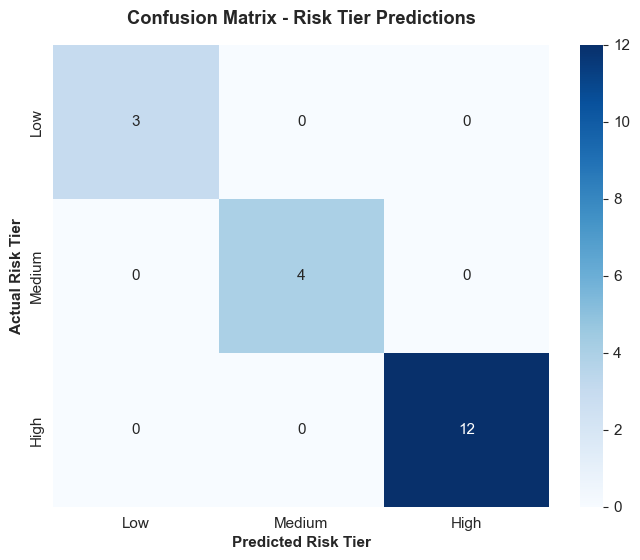

Interpretation: The diagonal shows correct predictions
Off-diagonal cells show misclassifications


In [13]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - Risk Tier Predictions', fontweight='bold', pad=15)
plt.ylabel('Actual Risk Tier', fontweight='bold')
plt.xlabel('Predicted Risk Tier', fontweight='bold')
plt.show()

print("Interpretation: The diagonal shows correct predictions")
print("Off-diagonal cells show misclassifications")

### Feature Importance Analysis

This reveals which factors are most predictive of supplier risk.

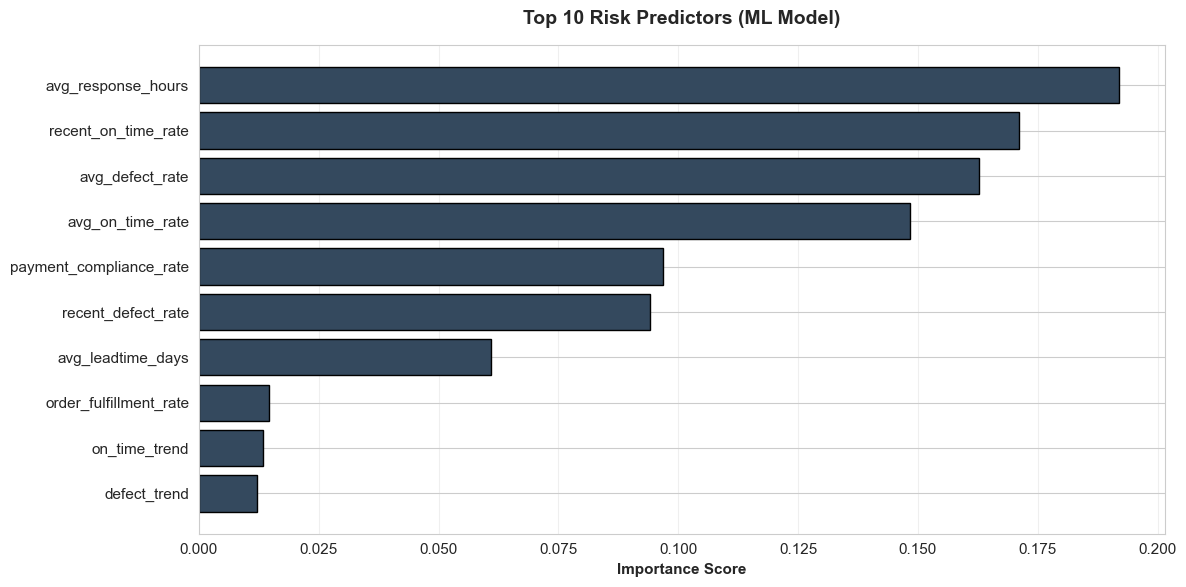


Top 5 Risk Predictors:
                feature  importance
     avg_response_hours    0.191863
    recent_on_time_rate    0.171178
        avg_defect_rate    0.162831
       avg_on_time_rate    0.148383
payment_compliance_rate    0.096755


In [14]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 10
plt.figure(figsize=(12, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='#34495e', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontweight='bold')
plt.title('Top 10 Risk Predictors (ML Model)', fontweight='bold', fontsize=14, pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 Risk Predictors:")
print(feature_importance.head(5).to_string(index=False))

---
## 5. Comprehensive Dashboard



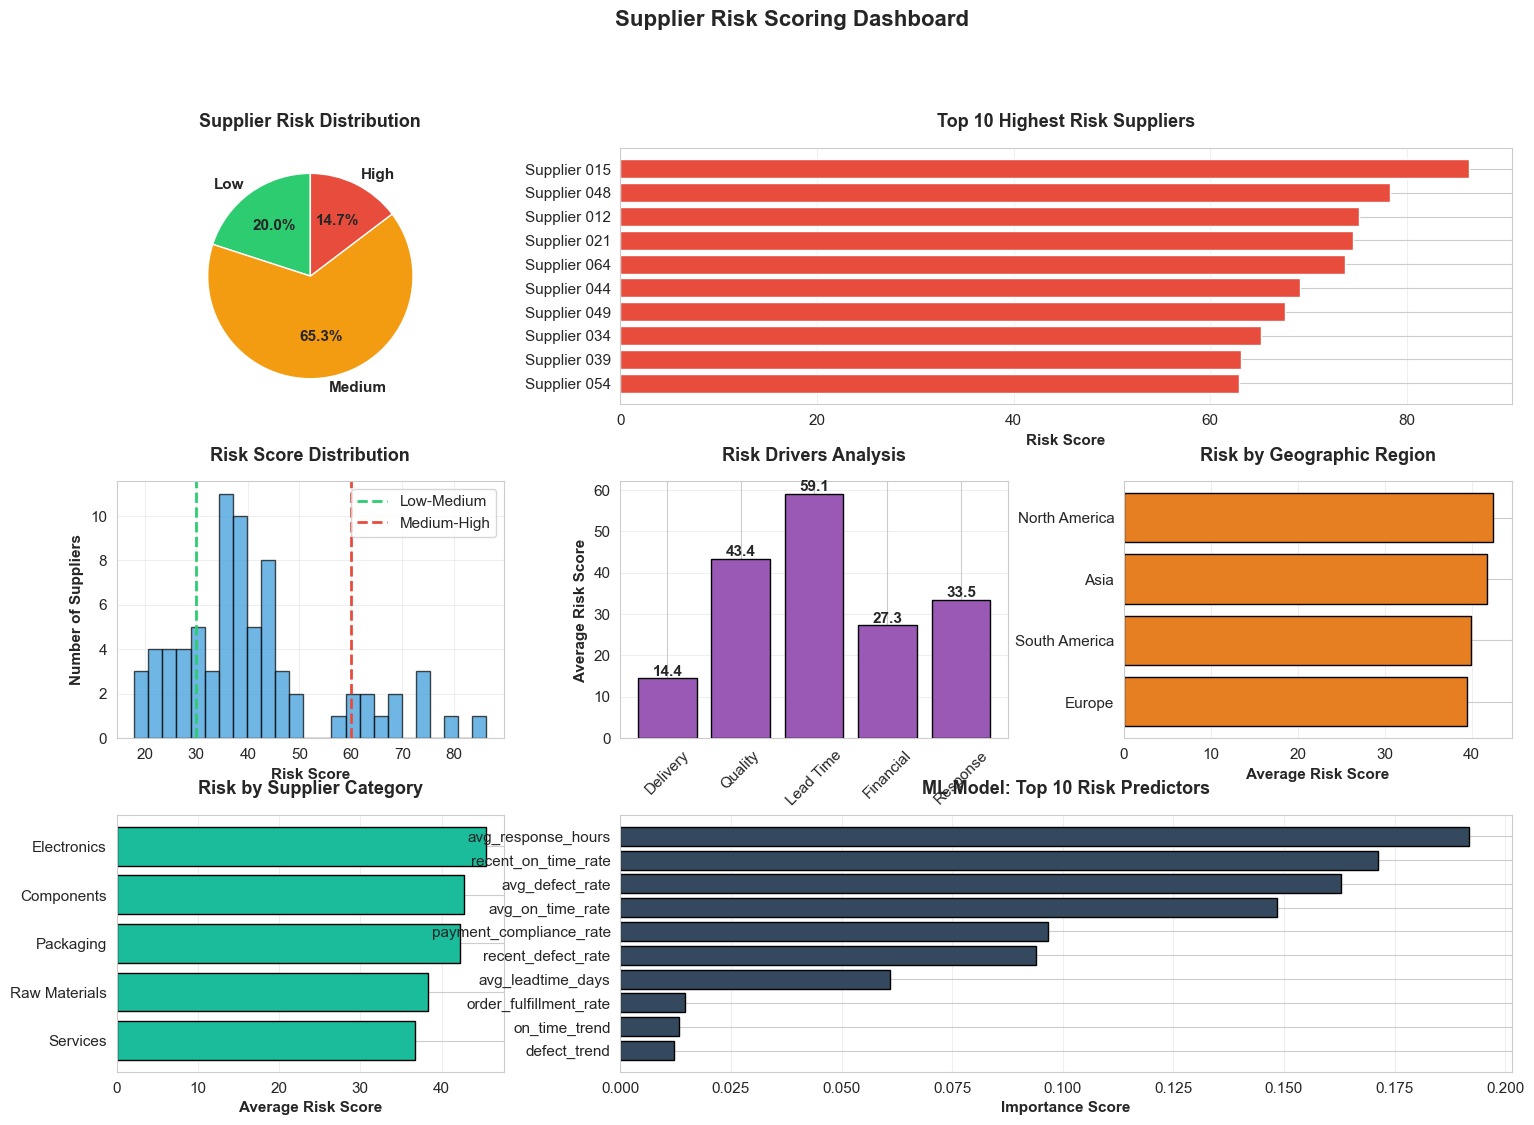

✓ Dashboard created and saved as 'supplier_risk_dashboard.png'


In [15]:
#comprehensive dashboard
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

colors = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c'}
risk_colors = [colors[tier] for tier in ['Low', 'Medium', 'High']]

# 1. Risk Distribution
ax1 = fig.add_subplot(gs[0, 0])
risk_counts = df['risk_tier'].value_counts().reindex(['Low', 'Medium', 'High'])
ax1.pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%',
        colors=risk_colors, startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
ax1.set_title('Supplier Risk Distribution', fontsize=13, fontweight='bold', pad=15)

# 2. Top 10 Highest Risk
ax2 = fig.add_subplot(gs[0, 1:])
top_risk = df.nlargest(10, 'risk_score')[['supplier_name', 'risk_score', 'risk_tier']]
bar_colors = [colors[tier] for tier in top_risk['risk_tier']]
ax2.barh(range(len(top_risk)), top_risk['risk_score'], color=bar_colors)
ax2.set_yticks(range(len(top_risk)))
ax2.set_yticklabels(top_risk['supplier_name'])
ax2.set_xlabel('Risk Score', fontweight='bold')
ax2.set_title('Top 10 Highest Risk Suppliers', fontsize=13, fontweight='bold', pad=15)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. Risk Score Distribution
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(df['risk_score'], bins=25, color='#3498db', edgecolor='black', alpha=0.7)
ax3.axvline(30, color='#2ecc71', linestyle='--', linewidth=2, label='Low-Medium')
ax3.axvline(60, color='#e74c3c', linestyle='--', linewidth=2, label='Medium-High')
ax3.set_xlabel('Risk Score', fontweight='bold')
ax3.set_ylabel('Number of Suppliers', fontweight='bold')
ax3.set_title('Risk Score Distribution', fontsize=13, fontweight='bold', pad=15)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Risk Components
ax4 = fig.add_subplot(gs[1, 1])
risk_components = {
    'Delivery': df['delivery_risk'].mean(),
    'Quality': df['quality_risk'].mean(),
    'Lead Time': df['leadtime_risk'].mean(),
    'Financial': df['financial_risk'].mean(),
    'Response': df['responsiveness_risk'].mean()
}
bars = ax4.bar(risk_components.keys(), risk_components.values(), color='#9b59b6', edgecolor='black')
ax4.set_ylabel('Average Risk Score', fontweight='bold')
ax4.set_title('Risk Drivers Analysis', fontsize=13, fontweight='bold', pad=15)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# 5. Risk by Region
ax5 = fig.add_subplot(gs[1, 2])
region_risk = df.groupby('region')['risk_score'].mean().sort_values()
ax5.barh(region_risk.index, region_risk.values, color='#e67e22', edgecolor='black')
ax5.set_xlabel('Average Risk Score', fontweight='bold')
ax5.set_title('Risk by Geographic Region', fontsize=13, fontweight='bold', pad=15)
ax5.grid(axis='x', alpha=0.3)

# 6. Risk by Category
ax6 = fig.add_subplot(gs[2, 0])
category_risk = df.groupby('category')['risk_score'].mean().sort_values()
ax6.barh(category_risk.index, category_risk.values, color='#1abc9c', edgecolor='black')
ax6.set_xlabel('Average Risk Score', fontweight='bold')
ax6.set_title('Risk by Supplier Category', fontsize=13, fontweight='bold', pad=15)
ax6.grid(axis='x', alpha=0.3)

# 7. Feature Importance
ax7 = fig.add_subplot(gs[2, 1:])
top_features = feature_importance.head(10)
ax7.barh(range(len(top_features)), top_features['importance'], color='#34495e', edgecolor='black')
ax7.set_yticks(range(len(top_features)))
ax7.set_yticklabels(top_features['feature'])
ax7.set_xlabel('Importance Score', fontweight='bold')
ax7.set_title('ML Model: Top 10 Risk Predictors', fontsize=13, fontweight='bold', pad=15)
ax7.invert_yaxis()
ax7.grid(axis='x', alpha=0.3)

plt.suptitle('Supplier Risk Scoring Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('supplier_risk_dashboard.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Dashboard created and saved as 'supplier_risk_dashboard.png'")

---
## 6. Business Insights & Recommendations

In [16]:
# Generate business insights
total = len(df)
high_risk = df[df['risk_tier'] == 'High']
medium_risk = df[df['risk_tier'] == 'Medium']
low_risk = df[df['risk_tier'] == 'Low']

print("="*70)
print("EXECUTIVE SUMMARY - KEY FINDINGS")
print("="*70)

print(f"\n1. RISK DISTRIBUTION")
print(f"   • {len(low_risk)} suppliers ({len(low_risk)/total*100:.1f}%) classified as LOW risk")
print(f"   • {len(medium_risk)} suppliers ({len(medium_risk)/total*100:.1f}%) classified as MEDIUM risk")
print(f"   • {len(high_risk)} suppliers ({len(high_risk)/total*100:.1f}%) classified as HIGH risk")

print(f"\n2. FINANCIAL EXPOSURE")
total_high_risk_spend = high_risk['annual_spend'].sum()
total_spend = df['annual_spend'].sum()
print(f"   • High-risk suppliers represent ${total_high_risk_spend:,.0f} in annual spend")
print(f"   • This is {total_high_risk_spend/total_spend*100:.1f}% of total supplier spend")

print(f"\n3. PRIMARY RISK DRIVERS (ML Model)")
for i, row in feature_importance.head(3).iterrows():
    print(f"   • {row['feature']}: {row['importance']*100:.1f}% importance")

print(f"\n4. CRITICAL VULNERABILITIES")
single_source_high = df[(df['single_source'] == True) & (df['risk_tier'] == 'High')]
print(f"   • {len(single_source_high)} HIGH-RISK single-source suppliers (immediate diversification needed)")

critical_high = df[(df['critical_component'] == True) & (df['risk_tier'] == 'High')]
print(f"   • {len(critical_high)} HIGH-RISK critical component suppliers (production impact potential)")

expired_high = df[(df['contract_expiry_days'] < 0) & (df['risk_tier'] == 'High')]
print(f"   • {len(expired_high)} HIGH-RISK suppliers with expired contracts (compliance issue)")

print(f"\n5. GEOGRAPHIC CONCENTRATION")
high_risk_by_region = high_risk.groupby('region').size().sort_values(ascending=False)
if len(high_risk_by_region) > 0:
    top_region = high_risk_by_region.index[0]
    count = high_risk_by_region.iloc[0]
    print(f"   • {top_region}: {count} high-risk suppliers ({count/len(high_risk)*100:.1f}% of high-risk total)")
    print(f"   • Consider geographic diversification strategy")

print(f"\n6. PERFORMANCE TRENDS")
improving = df[df['on_time_trend'] > 0.05]
declining = df[df['on_time_trend'] < -0.05]
print(f"   • {len(improving)} suppliers showing improvement in delivery performance")
print(f"   • {len(declining)} suppliers showing declining delivery performance (monitor closely)")

print(f"\n7. MODEL PERFORMANCE")
print(f"   • Risk prediction accuracy: {test_accuracy*100:.1f}%")
print(f"   • Early warning capability: 30-60 days advance notice of potential issues")

print("\n" + "="*70)
print("RECOMMENDED ACTIONS")
print("="*70)
print(f"\n1. IMMEDIATE (Next 30 days):")
print(f"   • Review all {len(single_source_high)} single-source high-risk suppliers")
print(f"   • Initiate diversification planning")
print(f"   • Renew {len(expired_high)} expired high-risk contracts")

print(f"\n2. SHORT-TERM (Next 90 days):")
print(f"   • Conduct performance reviews with {len(medium_risk)} medium-risk suppliers")
print(f"   • Implement enhanced monitoring for declining suppliers")
print(f"   • Develop contingency plans for critical high-risk suppliers")

print(f"\n3. STRATEGIC (Next 6-12 months):")
print(f"   • Rebalance geographic exposure (reduce concentration in {top_region})")
print(f"   • Implement automated risk monitoring dashboard")
print(f"   • Incorporate external risk signals (geopolitical, weather, etc.)")

print("\n" + "="*70)

EXECUTIVE SUMMARY - KEY FINDINGS

1. RISK DISTRIBUTION
   • 15 suppliers (20.0%) classified as LOW risk
   • 49 suppliers (65.3%) classified as MEDIUM risk
   • 11 suppliers (14.7%) classified as HIGH risk

2. FINANCIAL EXPOSURE
   • High-risk suppliers represent $135,576,932 in annual spend
   • This is 13.4% of total supplier spend

3. PRIMARY RISK DRIVERS (ML Model)
   • avg_response_hours: 19.2% importance
   • recent_on_time_rate: 17.1% importance
   • avg_defect_rate: 16.3% importance

4. CRITICAL VULNERABILITIES
   • 3 HIGH-RISK single-source suppliers (immediate diversification needed)
   • 7 HIGH-RISK critical component suppliers (production impact potential)
   • 2 HIGH-RISK suppliers with expired contracts (compliance issue)

5. GEOGRAPHIC CONCENTRATION
   • Asia: 3 high-risk suppliers (27.3% of high-risk total)
   • Consider geographic diversification strategy

6. PERFORMANCE TRENDS
   • 14 suppliers showing improvement in delivery performance
   • 4 suppliers showing decli